# Generating Delta File for Fraud Detection

In [1]:
# Initialise a spark session
import pandas as pd
from collections import Counter
import os
from pyspark.sql import SparkSession
from pyspark.sql import functions as F


spark = (
    SparkSession.builder.appName("Fraud Detection")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "8g")  # Increase driver memory
    .config("spark.executor.memory", "8g")  # Increase executor memory
    .config("spark.executor.instances", "4")  # Increase the number of executor instances
    .config("spark.driver.maxResultSize", "2g")
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/17 13:19:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Load Aggregated Data
transactions = spark.read.parquet('../data/curated/aggregated_data')

In [3]:
transactions.count()

16115994

## Defining Conditions for Fraudulent Transactions
* High fraud probability, either merchant or consumer is above a threshold value
* Unusually high dollar value in comparison to the user's typical order
* Frequent purchases within a short period

## Data Visualization
To determine threshold values for dollar value and purchase frequency, it can be helpful to visualize the distribution of the targeted variables.

### Dollar Value Distribution

24/09/17 13:19:14 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


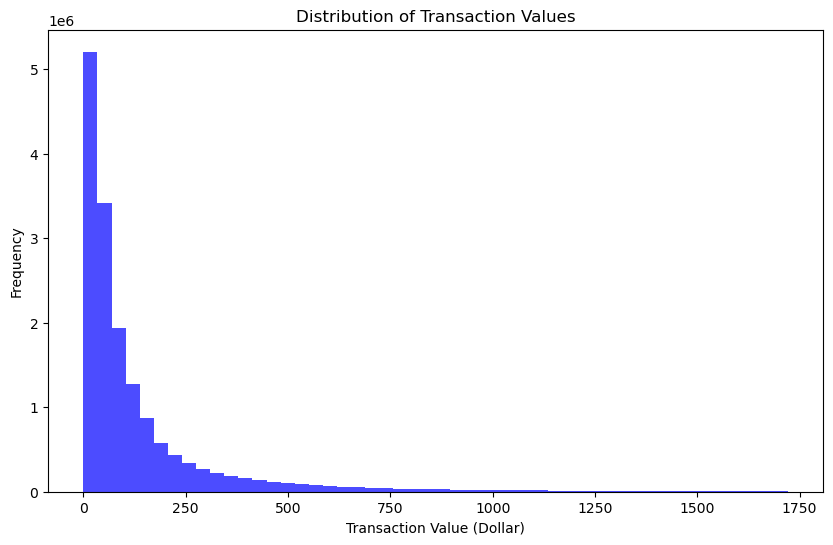

In [4]:
# Visualize the distribution of transaction values
import matplotlib.pyplot as plt

# Convert to Pandas for visualization
df_pandas = transactions.select("dollar_value").toPandas()

# Plot the distribution of dollar_value
plt.figure(figsize=(10,6))
plt.hist(df_pandas['dollar_value'], bins=50, color='blue', alpha=0.7)
plt.xlabel('Transaction Value (Dollar)')
plt.ylabel('Frequency')
plt.title('Distribution of Transaction Values')
plt.show()

### Fraud Probability Distribution

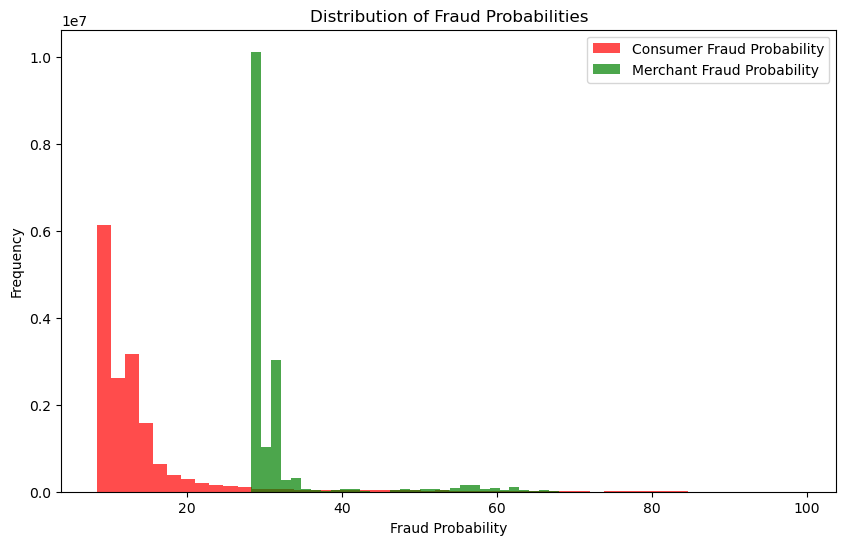

In [5]:
df_pandas_fraud_prob = transactions.select("fraud_probability_consumer", "fraud_probability_merchant").toPandas()

plt.figure(figsize=(10,6))
plt.hist(df_pandas_fraud_prob['fraud_probability_consumer'], bins=50, color='red', alpha=0.7, label="Consumer Fraud Probability")
plt.hist(df_pandas_fraud_prob['fraud_probability_merchant'], bins=50, color='green', alpha=0.7, label="Merchant Fraud Probability")
plt.xlabel('Fraud Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Fraud Probabilities')
plt.legend()
plt.show()


### Purchase Frequency (per Week)

In [6]:
# Extract the week and year
transactions = transactions.withColumn("week_of_year", F.weekofyear("order_datetime"))
transactions = transactions.withColumn("year", F.year("order_datetime"))

# Combine year and and week
transactions = transactions.withColumn("year_week", F.concat_ws("-", F.col("year"), F.col("week_of_year")))

transactions = transactions.drop("week_of_year", "year")
transactions.select("order_datetime", "year_week").show(10)

+--------------+---------+
|order_datetime|year_week|
+--------------+---------+
|    2021-11-20|  2021-46|
|    2021-11-20|  2021-46|
|    2021-11-20|  2021-46|
|    2021-11-20|  2021-46|
|    2021-11-20|  2021-46|
|    2021-11-20|  2021-46|
|    2021-11-20|  2021-46|
|    2021-11-20|  2021-46|
|    2021-11-20|  2021-46|
|    2021-11-20|  2021-46|
+--------------+---------+
only showing top 10 rows



#### Consumer Purchase Frequency

In [7]:
# Count the number of transactions per consumer (user_id) per year_week
consumer_weekly_transactions = transactions.groupBy("user_id", "year_week").count()
consumer_weekly_transactions = consumer_weekly_transactions.withColumnRenamed("count", "consumer_weekly_transaction")

consumer_weekly_transactions.show(10)


+-------+---------+---------------------------+
|user_id|year_week|consumer_weekly_transaction|
+-------+---------+---------------------------+
|   1994|  2021-37|                        569|
|   3929|  2021-46|                        581|
|  14014|  2021-52|                       1158|
|  20580|  2021-50|                        585|
|  12401|  2021-46|                        588|
|  13977|  2021-51|                        580|
|  18450|  2021-34|                        594|
|  19913|  2021-46|                       1160|
|  21258|  2021-48|                        573|
|  22422|  2021-46|                        576|
+-------+---------+---------------------------+
only showing top 10 rows



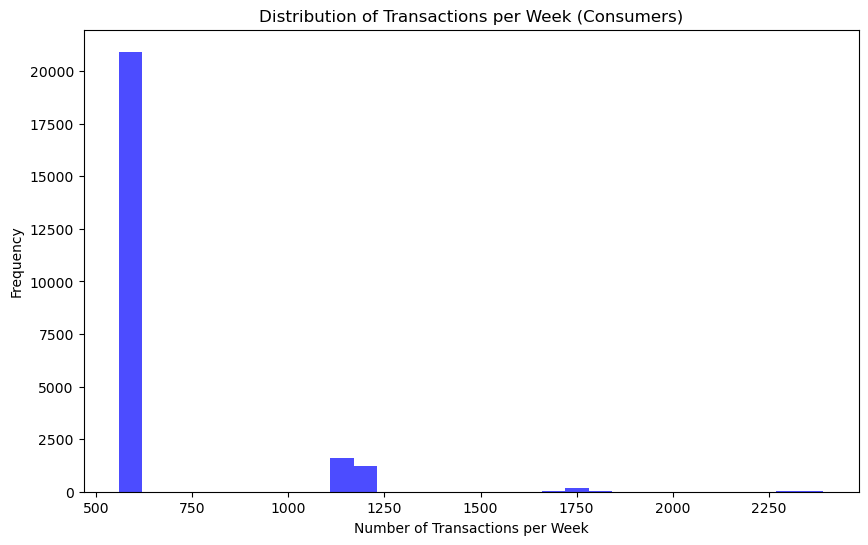

In [8]:
# Convert to Pandas DataFrame for plotting
consumer_weekly_transactions_pandas = consumer_weekly_transactions.select("consumer_weekly_transaction").toPandas()

# Plot the distribution of transactions per week
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(consumer_weekly_transactions_pandas["consumer_weekly_transaction"], bins=30, color="blue", alpha=0.7)
plt.xlabel("Number of Transactions per Week")
plt.ylabel("Frequency")
plt.title("Distribution of Transactions per Week (Consumers)")
plt.show()

#### Merchant Purchase Frequency

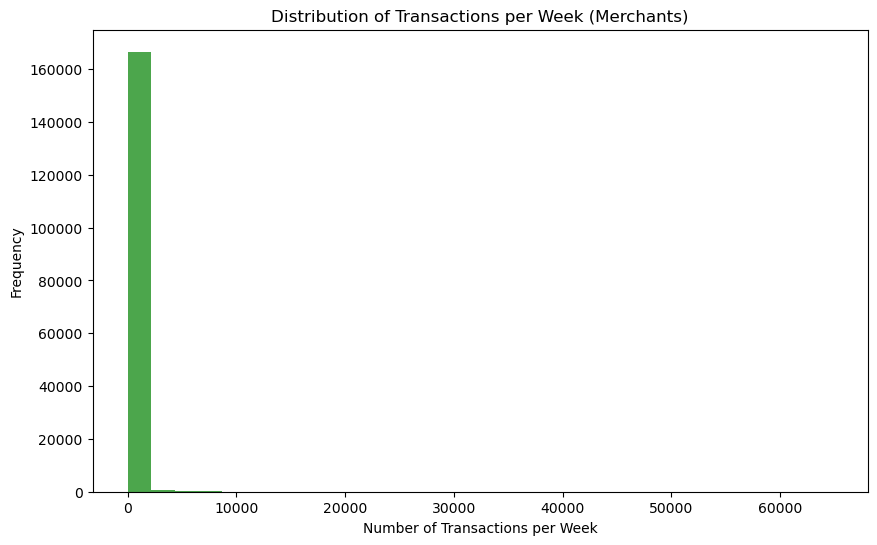

In [9]:
merchant_weekly_transactions = transactions.groupBy("merchant_abn", "year_week").count()

merchant_weekly_transactions = merchant_weekly_transactions.withColumnRenamed("count", "merchant_weekly_transaction")

merchant_weekly_transactions_pandas = merchant_weekly_transactions.select("merchant_weekly_transaction").toPandas()

plt.figure(figsize=(10, 6))
plt.hist(merchant_weekly_transactions_pandas["merchant_weekly_transaction"], bins=30, color="green", alpha=0.7)
plt.xlabel("Number of Transactions per Week")
plt.ylabel("Frequency")
plt.title("Distribution of Transactions per Week (Merchants)")
plt.show()


### Determining Threhold Values by Percentile
* For fraud probability, the threshold will be determined by visualization.
* Percentile values are used as guidance.

In [15]:
# Calculate the 90th percentile of weekly transactions for consumers
transaction_count_90th = consumer_weekly_transactions.approxQuantile("consumer_weekly_transaction", [0.90], 0.01)[0]
print(f"90th Percentile for Transaction Count per Week (Consumers): {transaction_count_90th}")

# Calculate the 90th percentile for merchants
merchant_transaction_count_90th = merchant_weekly_transactions.approxQuantile("merchant_weekly_transaction", [0.90], 0.01)[0]
print(f"90th Percentile for Transaction Count per Week (Merchants): {merchant_transaction_count_90th}")

90th Percentile for Transaction Count per Week (Consumers): 1150.0


90th Percentile for Transaction Count per Week (Merchants): 144.0


In [16]:
# Calculate the 90th percentile of dollar_value for consumers
dollar_value_90th = transactions.approxQuantile("dollar_value", [0.90], 0.01)[0]
print(f"90th Percentile for Dollar Value: {dollar_value_90th}")

# Calculate the 95th percentile of dollar_value for more extreme cases
dollar_value_95th = transactions.approxQuantile("dollar_value", [0.95], 0.01)[0]
print(f"95th Percentile for Dollar Value: {dollar_value_95th}")

90th Percentile for Dollar Value: 325.2262904243459


95th Percentile for Dollar Value: 520.8081232314929


## Flagging Fraud Transactions

In [18]:
consumer_weekly_transactions.printSchema()
merchant_weekly_transactions.printSchema()

root
 |-- user_id: long (nullable = true)
 |-- year_week: string (nullable = false)
 |-- consumer_weekly_transaction: long (nullable = false)

root
 |-- merchant_abn: long (nullable = true)
 |-- year_week: string (nullable = false)
 |-- merchant_weekly_transaction: long (nullable = false)



In [19]:
transactions = transactions.join(consumer_weekly_transactions, on=["user_id","year_week"], how="left")
transactions = transactions.join(merchant_weekly_transactions, on=["merchant_abn", "year_week"], how="left")

transactions.show(5)

+------------+---------+-------+------------------+--------------------+-----------+--------------------------+-------------+-----------------+--------------+-----------------+---------------+--------------------+--------------------+--------------------------+--------------+----------------+-------------+-------------+-----------------+--------------------+---------------------------+---------------------------+
|merchant_abn|year_week|user_id|      dollar_value|            order_id|consumer_id|fraud_probability_consumer|name_consumer| address_consumer|state_consumer|postcode_consumer|gender_consumer|       name_merchant|                tags|fraud_probability_merchant|order_datetime|order_month_year|SA4_CODE_2011|SA4_NAME_2011|unemployment_rate|             z_score|consumer_weekly_transaction|merchant_weekly_transaction|
+------------+---------+-------+------------------+--------------------+-----------+--------------------------+-------------+-----------------+--------------+--------

In [20]:
transactions_null = transactions.agg(
    *(F.sum(F.when(F.col(c).isNull(), 1).otherwise(0)).alias(c) for c in transactions.columns)
)
transactions_null.show()

+------------+---------+-------+------------+--------+-----------+--------------------------+-------------+----------------+--------------+-----------------+---------------+-------------+----+--------------------------+--------------+----------------+-------------+-------------+-----------------+-------+---------------------------+---------------------------+
|merchant_abn|year_week|user_id|dollar_value|order_id|consumer_id|fraud_probability_consumer|name_consumer|address_consumer|state_consumer|postcode_consumer|gender_consumer|name_merchant|tags|fraud_probability_merchant|order_datetime|order_month_year|SA4_CODE_2011|SA4_NAME_2011|unemployment_rate|z_score|consumer_weekly_transaction|merchant_weekly_transaction|
+------------+---------+-------+------------+--------+-----------+--------------------------+-------------+----------------+--------------+-----------------+---------------+-------------+----+--------------------------+--------------+----------------+-------------+-----------

### Feature Engineering
Add 'is_fraud' column to flag fraud transactions based on:
* If a transaction dollar_value is above the threshold of 520
* If the frequency of weekly transaction is above the threshold of 1150 (for consumer) or 140 (for merchant)
* If the fraud probability is above the threshold of 50 (for consumer) or 55 (for merchant)

If 2 or more of the criteria is met, a transaction would be flagged as fraudulent.

In [28]:
# Set Threshold Values

cons_freq_threhold = 1000
merch_freq_threhold = 140
dollar_threshold = 500
cons_fraud_threshold = 50
merch_fraud_threshold = 55

In [42]:
# Create columns to represent if each condition is met
transactions = transactions.withColumn(
    "condition1", F.when(F.col("fraud_probability_consumer") >= cons_fraud_threshold, 1).otherwise(0)
).withColumn(
    "condition2", F.when(F.col("fraud_probability_merchant") >= merch_fraud_threshold, 1).otherwise(0)
).withColumn(
    "condition3", F.when(F.col("dollar_value") >= dollar_threshold, 1).otherwise(0)
).withColumn(
    "condition4", F.when(F.col("consumer_weekly_transaction") > cons_freq_threhold, 1).otherwise(0)
).withColumn(
    "condition5", F.when(F.col("merchant_weekly_transaction") > merch_freq_threhold, 1).otherwise(0)
)

# Sum the conditions to determine how many criteria are met
transactions = transactions.withColumn(
    "criteria_met", F.col("condition1") + F.col("condition2") + F.col("condition3") + F.col("condition4") + F.col("condition5")
)

# Flag as fraud if at least 2 out of 5 criteria are met
transactions = transactions.withColumn(
    "is_fraud", F.when(F.col("criteria_met") >= 2, F.lit(True)).otherwise(F.lit(False))
)

transactions = transactions.drop("condition1", "condition2", "condition3", "condition4", "condition5", "criteria_met")

transactions.select("order_id", "is_fraud").show(10)

+--------------------+--------+
|            order_id|is_fraud|
+--------------------+--------+
|00a486bb-258e-476...|   false|
|0003becc-28c1-44f...|   false|
|0029028b-65b3-449...|   false|
|01ace3b8-f331-4c6...|   false|
|011815db-1418-405...|   false|
|02f50243-07df-419...|   false|
|02763734-a451-4c1...|   false|
|00f75c23-77c1-4a1...|   false|
|00c09e20-086a-489...|   false|
|014a1f62-8f5d-446...|   false|
+--------------------+--------+
only showing top 10 rows



In [43]:
print(transactions.filter(F.col("is_fraud") == True).count())
print(transactions.filter(F.col("is_fraud") == False).count())

4198951


11917043


In [44]:
transactions.printSchema()

root
 |-- merchant_abn: long (nullable = true)
 |-- year_week: string (nullable = false)
 |-- user_id: long (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- consumer_id: long (nullable = true)
 |-- fraud_probability_consumer: double (nullable = true)
 |-- name_consumer: string (nullable = true)
 |-- address_consumer: string (nullable = true)
 |-- state_consumer: string (nullable = true)
 |-- postcode_consumer: integer (nullable = true)
 |-- gender_consumer: string (nullable = true)
 |-- name_merchant: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- fraud_probability_merchant: double (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- order_month_year: string (nullable = true)
 |-- SA4_CODE_2011: string (nullable = true)
 |-- SA4_NAME_2011: string (nullable = true)
 |-- unemployment_rate: string (nullable = true)
 |-- z_score: double (nullable = true)
 |-- consumer_weekly_transaction: long (nullab

In [45]:
transactions.write.parquet('../data/curated/flagged_fraud')